##  Cross Validation
Inseption v3 model adapted from:

https://pytorch.org/docs/stable/torchvision/models.html

https://scikit-learn.org/stable/modules/cross_validation.html

https://scikit-learn.org/stable/modules/grid_search.html#grid-search

https://github.com/skorch-dev/skorch


In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim

#import torch.nn.functional as F
#from torch.autograd import Variable

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.models

import os
import sys
import copy
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn import metrics

from  livelossplot import PlotLosses

In [7]:
# Import MonaLIA library from the package in the subfolder of the notebook folder
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import importlib

import MonaLIA.data.image_transforms as image_transforms

from MonaLIA.model.train import load_net, set_optimizer, train
from MonaLIA.model.train import decision_by_threshold, decision_by_max, decision_by_topk
from MonaLIA.model.train import predict
from MonaLIA.data.image_dataset import JocondeDataset
from MonaLIA.data.image_transforms import NormalizeMultiCrop

from MonaLIA.util.visualization_helpers import show_random_images
from MonaLIA.util.visualization_helpers import visualize_classification_from_tensor as visualizer

In [3]:
images_root = 'C:\\Joconde\\joconde'
descr_path = 'C:\\Joconde\\joconde\\Humans and Horses and Birds and Dogs'
dataset = 'dataset1_cv.csv'
is_disjoint = True
multi_label = True

model_name = 'inception_v3'
input_size = 299
batch_size = 4   
finetuning = True
score_threshold = 0.5

### Preload Data
to check if everything is ok

In [4]:
dataset_mean = [0.5, 0.5, 0.5] #image_transforms.joconde_mean_animals 
dataset_std  = [0.5, 0.5, 0.5] #image_transforms.joconde_std_animals 

train_trans = transforms.Compose([
    #transforms.Resize(256),
    transforms.RandomResizedCrop(input_size),
    #transforms.CenterCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = dataset_mean,
                         std = dataset_std),
])

val_trans = transforms.Compose([
    transforms.Resize(max(256, input_size)), 
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean = dataset_mean,
                         std = dataset_std),
])


image_description_file = os.path.join(descr_path, dataset)

if (is_disjoint):
    exclude_labels = ['équidé+être humain', 'none+none']  
else:
    exclude_labels = []


folds = ['train' + str(x) for x in range(10)]
folds.remove('train0')

train_set = JocondeDataset(image_description_file, 
                        images_root,
                        exclude_labels=exclude_labels ,
                        multiple_labels = multi_label,
                        filter_dict= {'usage': folds}, 
                        transform=train_trans)

val_set = JocondeDataset(image_description_file, 
                        images_root,
                        exclude_labels=exclude_labels  ,
                        multiple_labels = multi_label, 
                        filter_dict= {'usage': ['train0']}, 
                        transform=val_trans)

test_set = JocondeDataset(image_description_file, 
                        images_root,
                        exclude_labels=exclude_labels  ,
                        multiple_labels = multi_label, 
                        filter_dict= {'usage': ['test']}, 
                        add_columns=['ref', 'repr'],
                        transform=val_trans)


train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True,
                 num_workers=2)
val_loader = torch.utils.data.DataLoader(
                dataset=val_set,
                batch_size=batch_size,
                shuffle=False,
                num_workers=2)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False,
                num_workers=2)

class_count = len(test_set.classes)
class_names = test_set.classes

print ('total trainning set size: {}'.format(len(train_set)))
print ('total trainning batch count: {}'.format(len(train_loader)))

print ('total validation set size: {}'.format(len(val_set)))
print ('total validation batch count: {}'.format(len(val_loader)))

print ('total test set size: {}'.format(len(test_set)))
print ('total test batch count: {}'.format(len(test_loader)))

print (class_names)

total trainning set size: 3060
total trainning batch count: 765
total validation set size: 340
total validation batch count: 85
total test set size: 378
total test batch count: 95
['canidé', 'oiseau', 'équidé', 'être humain']


### Define the network



In [5]:
net = load_net(model_name = model_name, class_count=class_count, finetuning = finetuning)
net.input_transform = False
print(net)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

)


In [14]:
net.Mixed_7c.branch_pool.conv

torch.nn.modules.conv.Conv2d

### Set Hyperparameters

In [6]:
learning_rate = 0.001

epoch_count = 10

criterion = nn.BCEWithLogitsLoss()# nn.() CrossEntropyLoss   BCEWithLogitsLoss

optimizer = set_optimizer(net, optim.SGD, learning_rate = learning_rate, print_parameters= False)
    
# decay LR by a factor of 0.1 every 4 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

activation = torch.sigmoid
decision = decision_by_threshold
decision_param = 0.5

In [7]:
liveloss = PlotLosses(max_epoch=epoch_count)
def plot_epoch (epoch_stats):
    liveloss.update(epoch_stats)
    liveloss.draw()

In [13]:
%%time

net, best_epoch, best_loss, best_accuracy, elapsed_time = train(net, 
                                                                criterion, optimizer, scheduler, 
                                                                train_loader, val_loader,  
                                                                activation, decision, decision_param,
                                                                save_best_model=False, 
                                                                epochs_num = epoch_count,  end_of_epoch_callback=plot_epoch)
#net, logs, elapsed_time = train_model(model = net,
#                                    criterion= criterion,
#                                    optimizer=optimizer,
#                                    scheduler= scheduler,
#                                    train_loader = train_loader,
#                                    val_loader=val_loader,
#                                    epochs_num = epoch_count)

#best_train_acc = max([x['accuracy'] for x in logs])
#best_val_acc = max([x['val_accuracy'] for x in logs])
#best_epoch = [x['val_accuracy'] for x in logs].index(best_val_acc)

#print('Best model training accuracy: %.4f' % best_train_acc)
#print('Best model validation accuracy: %.4f' % best_val_acc)
#print('Best model epoch: %d' % (best_epoch + 1) )
#print('Training time: %s' % elapsed_time)

print('Best model training accuracy: %.4f' % best_accuracy['train'])
print('Best model validation accuracy: %.4f' % best_accuracy['val'])
print('Best model epoch: %d' % (best_epoch + 1) )
print('Training time: %s' % str(elapsed_time))

Epoch 1 of 10


RuntimeError: CUDA out of memory. Tried to allocate 2.63 MiB (GPU 0; 4.00 GiB total capacity; 852.07 MiB already allocated; 1.64 MiB free; 29.80 MiB cached)

### Cross Validation

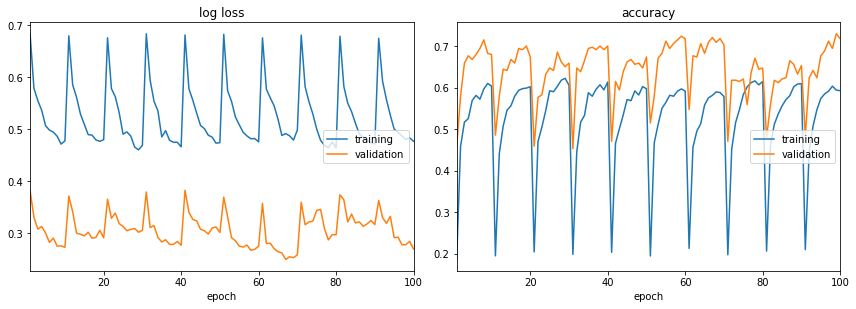


Best model training accuracy: 0.6033
Best model validation accuracy: 0.7294
Best model epoch: 9
Training time: 0:46:56.594786
[0.7147058823529412, 0.7, 0.6852941176470588, 0.7, 0.6735294117647059, 0.7235294117647059, 0.7205882352941176, 0.6705882352941176, 0.6647058823529411, 0.7294117647058823]
Model Accuracy: 0.70 (+/- 0.04)
Wall time: 7h 23min 36s


In [8]:
%%time
#learning_rate = 0.001

#epoch_count = 10

#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()


folds = ['train' + str(x) for x in range(10)]

model_accuracy = []
total_elapsed_time = datetime.timedelta(0)

#use_cuda = torch.cuda.is_available()

liveloss = PlotLosses(max_epoch=epoch_count*len(folds))

for f, fold in enumerate(folds):
 
    print('Cross validation run %d of %d' % (f+1, len(folds)) )
    
    val_fold = [fold]
    train_folds = folds.copy()
    train_folds.remove(fold)
    
    train_loader.dataset = JocondeDataset(image_description_file, 
                                            images_root,
                                            exclude_labels=exclude_labels ,
                                            multiple_labels = multi_label,
                                            filter_dict= {'usage': train_folds}, 
                                            transform=train_trans)

    val_loader.dataset = JocondeDataset(image_description_file, 
                                            images_root,
                                            exclude_labels=exclude_labels  ,
                                            multiple_labels = multi_label, 
                                            filter_dict= {'usage': val_fold}, 
                                            transform=val_trans)
    
    #net = load_net(model_name= model_name , class_count=class_count, finetuning=finetuning)
    net = load_net(model_name= model_name , class_count=class_count, finetuning=finetuning)
    
    #if use_cuda:
    #    net = net.cuda()
    
    optimizer = set_optimizer(net, optim.SGD, learning_rate=learning_rate)
    
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
        
    #net, logs, elapsed_time = train_model(model = net,
    #                                criterion= criterion,
    #                                optimizer=optimizer,
    #                                scheduler= scheduler,
    #                                train_loader = train_loader,
    #                                val_loader=val_loader,
    #                                epochs_num = epoch_count,
    #                                show_plot=False)
    
    net, best_epoch, best_loss, best_accuracy, elapsed_time = train(net, 
                                                                criterion, optimizer, scheduler, 
                                                                train_loader, val_loader,  
                                                                activation, decision, decision_param,
                                                                save_best_model=False, 
                                                                epochs_num = epoch_count,  
                                                                end_of_epoch_callback=plot_epoch)

    #best_train_acc = max([x['accuracy'] for x in logs])
    #best_val_acc = max([x['val_accuracy'] for x in logs])
    #best_epoch = [x['val_accuracy'] for x in logs].index(best_val_acc)
    
    best_train_acc = best_accuracy['train']
    best_val_acc = best_accuracy['val']
        

    print('Best model training accuracy: %.4f' % best_train_acc)
    print('Best model validation accuracy: %.4f' % best_val_acc)
    print('Best model epoch: %d' % (best_epoch + 1) )
    print('Training time: %s' % elapsed_time)
    
    
    if ( (len(model_accuracy) == 0) or (best_val_acc > max(model_accuracy)) ):
        #save the best model
        torch.save(net.state_dict(), './Model Parameters/Inception_v3_Joconde_human_vs_dogs_vs_horses_vs_birds.1000.6.cv.pth')
    
    model_accuracy.append(best_val_acc)
    total_elapsed_time += elapsed_time
    
    
print(model_accuracy)    
print("Model Accuracy: %0.2f (+/- %0.2f)" % (np.asarray(model_accuracy).mean(), np.asarray(model_accuracy).std() * 2))
        

In [19]:
model_accuracy

[0.8777777777777778,
 0.8722222222222222,
 0.8777777777777778,
 0.8777777777777778,
 0.8833333333333333,
 0.9,
 0.85,
 0.85,
 0.8611111111111112,
 0.8555555555555555]

### Testing

In [21]:
scores = predict(net, test_loader, activation, decision, decision_param)

images total: 100, correct: 93.0, acc: 93.000%
images total: 200, correct: 177.0, acc: 88.500%
images total: 200, correct: 177.0, acc: 88.500%
Finished prediction


### Show Statistics

In [22]:
scores = scores.cpu() 

y_true = np.array(test_set.targets)
y_pred = decision(scores[:,1:], decision_param)

prfs = metrics.precision_recall_fscore_support(y_true= y_true,
                                               y_pred= y_pred)

acc = metrics.accuracy_score(y_true= y_true,
                            y_pred= y_pred)



sim = metrics.jaccard_similarity_score(y_true= y_true,
                                       y_pred= y_pred)
output = pd.concat((pd.Series(test_set.classes) ,
           pd.Series(prfs[3].round(3)),         
           pd.Series(prfs[1].round(3)),
           pd.Series(prfs[0].round(3)),
           pd.Series(prfs[2].round(3)),
           pd.Series(prfs[2].mean().round(3)),         
           pd.Series(acc.round(3)),
           pd.Series(sim.round(3)),
           pd.Series(decision_param)),
           axis=1 )
output.columns = ['class',  'support', 'recall', 'precision', 'f1 score', 'f1 avg', 'accuracy', 'jaccard similarity score' , 'threshold']
output

,class,support,recall,precision,f1 score,f1 avg,accuracy,jaccard similarity score,threshold
0,équidé,100,0.90,0.882,0.891,0.888,0.885,0.888,0.5
1,être humain,100,0.88,0.889,0.884,NaN,NaN,NaN,NaN


In [47]:
print(metrics.classification_report(y_true= np.array(test_set.targets),
                             y_pred= (classified > score_threshold).cpu().numpy(), target_names=test_set.classes))

                precision    recall  f1-score   support

espèce animale       0.94      0.82      0.88       100
   être humain       0.83      0.95      0.89       100

     micro avg       0.88      0.89      0.88       200
     macro avg       0.89      0.89      0.88       200
  weighted avg       0.89      0.89      0.88       200
   samples avg       0.88      0.89      0.88       200



In [23]:
report = metrics.classification_report(y_true= y_true,
                                 y_pred= y_pred, 
                                 target_names = test_set.classes,
                                 output_dict = True)

report_output = pd.concat((pd.Series([x for x in report] ),
                           pd.Series([x['support'] for x in report.values()]),
                           pd.Series([x['recall'] for x in report.values()]).round(3),
                           pd.Series([x['precision'] for x in report.values()]).round(3),
                           pd.Series([x['f1-score'] for x in report.values()]).round(3),
                           pd.Series(report['macro avg']['f1-score']).round(3),
                           pd.Series(acc).round(3),
                           pd.Series(sim).round(3),
                           pd.Series(decision_param)
                           ), axis=1)
report_output.columns = ['class', 'support', 'recall', 'precision', 'f1-score', 'f1 macroavg','accuracy', 'jaccard similarity score' , 'param']

report_output

,class,support,recall,precision,f1-score,f1 macroavg,accuracy,jaccard similarity score,param
0,équidé,100,0.90,0.882,0.891,0.888,0.885,0.888,0.5
1,être humain,100,0.88,0.889,0.884,NaN,NaN,NaN,NaN
2,micro avg,200,0.89,0.886,0.888,NaN,NaN,NaN,NaN
3,macro avg,200,0.89,0.886,0.888,NaN,NaN,NaN,NaN
4,weighted avg,200,0.89,0.886,0.888,NaN,NaN,NaN,NaN
5,samples avg,200,0.89,0.888,0.888,NaN,NaN,NaN,NaN


In [ ]:
# this function will be available in scikit-learn 0.21 currently in beta
metrics.confusion_matrix(y_true= np.array(test_set.targets),
                                               y_pred= (classified > score_threshold).cpu().numpy())

## Scrapbook

In [24]:
np.savetxt('./Model Parameters/CV__%s__%s' % (model_name , dataset), np.asarray(model_accuracy),fmt='%.16f', delimiter=",")

In [106]:
??os.path.join

In [5]:
def load_net (model_name = "vgg16_bn", class_count=2, finetuning=False):
    if model_name == "inception_v3":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        net = torchvision.models.inception_v3(pretrained=True)
        
        if (not finetuning):
            for param in net.parameters():
                param.requires_grad = False

        net.AuxLogits.fc = nn.Linear(net.AuxLogits.fc.in_features, class_count)
        net.fc = nn.Linear(net.fc.in_features, class_count)

    elif model_name == 'vgg16_bn':
        net = torchvision.models.vgg16_bn(pretrained=True)
        
        if (not finetuning):
            for param in net.parameters():
                param.requires_grad = False
        
        # Replace the last layer and it will unfreeze it as well
        net.classifier[len(net.classifier)-1] = nn.Linear(net.classifier[len(net.classifier)-1].in_features, class_count)    
    
        # Attach this attribute to the network to be able to distinguish between having and not having the auxilary output
        net.__setattr__('aux_logits', False)
    
    return  net   


In [7]:
def set_optimizer(model, optimizer_type, learning_rate = 0.001, print_parameters= False):

    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            if print_parameters:
                print("\t",name)
    
    optimizer = optimizer_type(params_to_update, lr=learning_rate, momentum=0.9) ##will not work with optim.Adam
    
    return optimizer

In [8]:
learning_rate = 0.001

epoch_count = 10

#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
#criterion_m = nn.BCELoss()


optimizer = set_optimizer(net, optim.SGD, learning_rate=learning_rate)
    
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [ ]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    net = net.cuda()

In [9]:
def train_model(model, criterion, optimizer, scheduler,  train_loader, val_loader, epochs_num = 10, 
                show_plot = True, save_best_model=False):
  
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    best_train_acc = 0.0
    best_train_loss = 1.0

    t0 = datetime.datetime.now()

    liveloss = PlotLosses(max_epoch=epochs_num)

    for epoch in range(epochs_num):

        print('Epoch %d of %d' % (epoch+1, epochs_num) )

        logs = {}

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step() 
                model.train()  # Set model to training mode
                data_loader = train_loader
                dataset_size = len(train_loader.dataset)
            else:
                model.eval()   # Set model to evaluate mode
                data_loader = val_loader
                dataset_size = len(val_loader.dataset)

            running_loss = 0.0
            running_corrects = 0

            for batch_idx, (img, target) in enumerate(data_loader):

                target = torch.stack(target).t().float()

                # use GPU if possible
                img = img.to(device)
                target =  target.to(device) 

                 # zero the parameter gradients
                optimizer.zero_grad()


                with torch.set_grad_enabled(phase == 'train'):

                    #forward
                    #if (img.dim() < 5):
                    #    output, aux_output = model(img)
                    #else:
                        #5 crops
                    #    bs, ncrops, c, h, w = img.size()
                    #    output, aux_output = model(img.view(-1, c, h, w)).view(bs, ncrops, -1).mean(1)  # fuse batch size and ncrops & avg crops
                        #output = output_crops.view(bs, ncrops, -1).mean(1) # avg over crops

                    #sm = nn.Softmax(dim=1)
                    #loss = criterion_m(sm(output), target)
                    #loss = criterion_m(output, target)


                    # backprop only for train phase
                    if phase == 'train':
                        if(model.aux_logits):
                            output, aux_output = model(img)
                            loss1 = criterion(output, target)
                            loss2 = criterion(aux_output, target)
                            loss = loss1 + 0.4*loss2
                        else:
                            output = model(img)
                            loss = criterion(output, target)

                        loss.backward()
                        optimizer.step()
                    else:
                        output = model(img)
                        loss = criterion(output, target)

                # statistics
                running_loss += loss.item() * img.size(0)
                running_corrects += torch.sum( (torch.sum((nn.functional.sigmoid(output) > score_threshold)==target.byte(), dim=1) == target.shape[1]))


                t1 = datetime.datetime.now()
                if (batch_idx % 100 == 0):
                    print('\rImages processed: %d      Time elapsed: %s' % (batch_idx*batch_size , str(t1-t0)), end='')


            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double().item() / dataset_size #* target.shape[1])


            # deep copy the model
            if phase == 'val' and epoch_acc > best_val_acc and epoch > 0:
            #if phase == 'train' and epoch_loss < best_train_loss and epoch > 0:
                best_val_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
                best_train_acc = train_acc
                best_train_loss = epoch_loss
                best_epoch = epoch
                print('*', end='')
            if  phase == 'train':
                train_acc = epoch_acc

            #store values for plotting
            prefix = 'val_' if phase == 'val' else ''
            logs[prefix + 'log loss'] = epoch_loss
            logs[prefix + 'accuracy'] = epoch_acc


        # plot 
        liveloss.update(logs)
        
        if(show_plot):
            liveloss.draw()

        print() #end of epoch


    # load best model weights
    model.load_state_dict(best_model_weights)
    
    # Save before you forget
    if (save_best_model):
        fn = '_last_training_%s.pth' % datetime.datetime.now().strftime('%b_%d_%H_%M')
        torch.save(model.state_dict(), fn)
    
    return model , liveloss.logs, t1-t0


In [20]:
total_cnt = 0
correct_cnt = 0

#top_k  = min(5, len(test_set.classes))

classified = torch.empty(0, dtype=torch.float)

# Set model to evaluate mode
net.eval()  

for batch_idx, (img, target) in enumerate(test_loader):
    
    target = torch.stack(target).t().float()
    
    if use_cuda:
        img, target = img.cuda(), target.cuda()
        classified = classified.cuda()
        
    with torch.no_grad():
        #run model
        if (img.dim() < 5):
            out = net(img)
        else:
            #5 crops
            bs, ncrops, c, h, w = img.size()
            out = net(img.view(-1, c, h, w)).view(bs, ncrops, -1).mean(1)  # fuse batch size and ncrops & avg crops

        
        out = nn.functional.sigmoid(out)
        pred_label = (out > score_threshold)
        #pred_prob, pred_label = torch.max(out.data, 1)
        #top5_prob, top5_label = torch.topk(out.data, top_k, 1) 
        
        
        #total_cnt +=  torch.numel(target)
        #correct_cnt += torch.sum((out > score_threshold)==target.byte())
        
        total_cnt += target.size()[0]
        correct_cnt += torch.sum( (torch.sum(pred_label==target.byte(), dim=1) == len(test_set.classes)))
          
        # display progress
        if total_cnt % 100 == 0 or total_cnt == len(test_loader):
            print( 'images total: {}, correct: {}, acc: {:.3f}%'.format(
                    total_cnt, correct_cnt, correct_cnt * 100.0 / total_cnt))
 

        classified= torch.cat((classified, out) )
    
                
print( 'images total: {}, correct: {}, acc: {:.3f}%'.format(
        total_cnt, correct_cnt, correct_cnt * 100.0 / total_cnt))

print('Finished testing')

NameError: name 'use_cuda' is not defined